##### Smart Flight Planning: Predictive Modeling and Analytics 

Sebastian Quirarte Justo | Fall 2025

### Contents
1. [Overview](#overview)
2. [Imports](#imports)
3. [Data](#data)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Modeling and Analysis](#modeling-and-analysis)
6. [Results](#results)

### Overview

The United States has the busiest and most complex commercial flight system in the world, with 16.1 million flights, 1.1 billion passengers, and 5,146 public use airports reported by the Federal Aviation Administration (FAA) from October 1, 2023, to September 30, 2024 (FY2024). According to the Bureau of Transportation Statistics (BTS), 21.5% of these flights were classified as not on-time, with the most frequent reasons being air carrier delays, national aviation system delays, and aircraft arriving late. This notebook loads and processes a full year of FY2024 flight data and conducts exploratory data analysis along with statistical modeling.

### Imports

In [ ]:
# Install xgboost if not curently installed
!pip install xgboost

In [ ]:
# Standard library
from pathlib import Path
import time

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


### Data

In [3]:

# Load and merge all CSV files
all_files = (Path(".").glob("*.csv"))
dfs = []
for file in all_files:
    dfs.append(pd.read_csv(file, low_memory=False))
df = pd.concat(dfs, ignore_index=True)


# Sort by date
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p')
df = df.sort_values('FL_DATE').reset_index(drop=True)

# Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7047267 entries, 0 to 7047266
Data columns (total 69 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   YEAR                     int64         
 1   QUARTER                  int64         
 2   MONTH                    int64         
 3   DAY_OF_MONTH             int64         
 4   DAY_OF_WEEK              int64         
 5   FL_DATE                  datetime64[ns]
 6   OP_UNIQUE_CARRIER        object        
 7   OP_CARRIER_AIRLINE_ID    int64         
 8   OP_CARRIER               object        
 9   TAIL_NUM                 object        
 10  OP_CARRIER_FL_NUM        float64       
 11  ORIGIN_AIRPORT_ID        int64         
 12  ORIGIN_AIRPORT_SEQ_ID    int64         
 13  ORIGIN_CITY_MARKET_ID    int64         
 14  ORIGIN                   object        
 15  ORIGIN_CITY_NAME         object        
 16  ORIGIN_STATE_ABR         object        
 17  ORIGIN_STATE_FIPS        in

### Exploratory Data Analysis

**Overall Delays**

In [4]:
# Flight delay overview
pd.options.display.float_format = '{:.2f}'.format
df['ARR_DELAY'].describe()

count   6937856.00
mean          6.49
std          57.17
min        -117.00
25%         -15.00
50%          -6.00
75%           9.00
max        3803.00
Name: ARR_DELAY, dtype: float64

- Half of all flights arrived 6 min early, and 75% arrived within 9 minutes of schedule.
- The mean delay time of 6.49 ± 57.17 min seems to be influenced by extreme delays.
- Most flights perform well, but outliers are severe, with a maximum delay of 3,803 min (63.4 hours)!

**Delays greater than 15 min:**

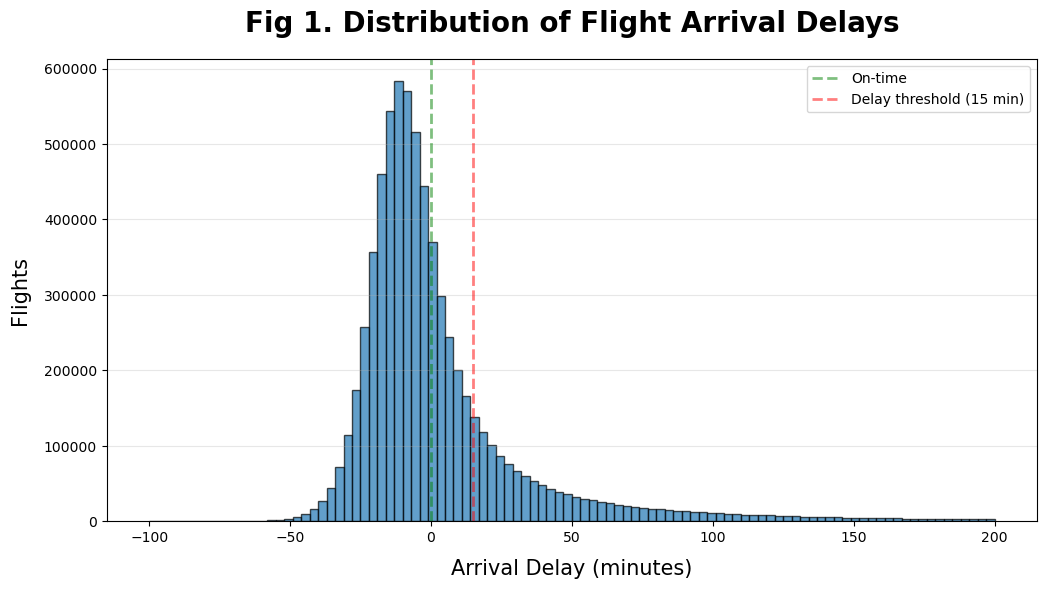

In [5]:
# Histogram of Flight Arrival Delays
plt.figure(figsize=(12, 6))
plt.hist(df['ARR_DELAY'], 
         bins=100, 
         range=(-100, 200), 
         edgecolor='black', 
         alpha=0.7)
plt.axvline(x=0, 
            color='green', 
            linestyle='--', 
            linewidth=2, 
            label='On-time',
            alpha=0.5)
plt.axvline(x=15, 
            color='red', 
            linestyle='--', 
            linewidth=2, 
            label='Delay threshold (15 min)',
            alpha=0.5)
plt.xlabel('Arrival Delay (minutes)', 
           fontsize=15,
           labelpad=10)
plt.ylabel('Flights', 
           fontsize=15,
           labelpad=10)
plt.title('Fig 1. Distribution of Flight Arrival Delays', 
          fontsize=20, 
          fontweight='bold',
          pad=20)
plt.legend()
plt.grid(axis='y', 
         alpha=0.3)
plt.show()

In [6]:
# Total flights
total_flights = len(df)

# Delayed flights (>15 min)
delayed_flights = (df['ARR_DELAY'] > 15).sum()

# Percentage
delay_rate = (delayed_flights / total_flights) * 100

print(f"Total flights: {total_flights:,}")
print(f"Delayed flights (>15 min): {delayed_flights:,}")
print(f"Delay rate: {delay_rate:.2f}%")

Total flights: 7,047,267
Delayed flights (>15 min): 1,361,523
Delay rate: 19.32%


**Delays by airline:**

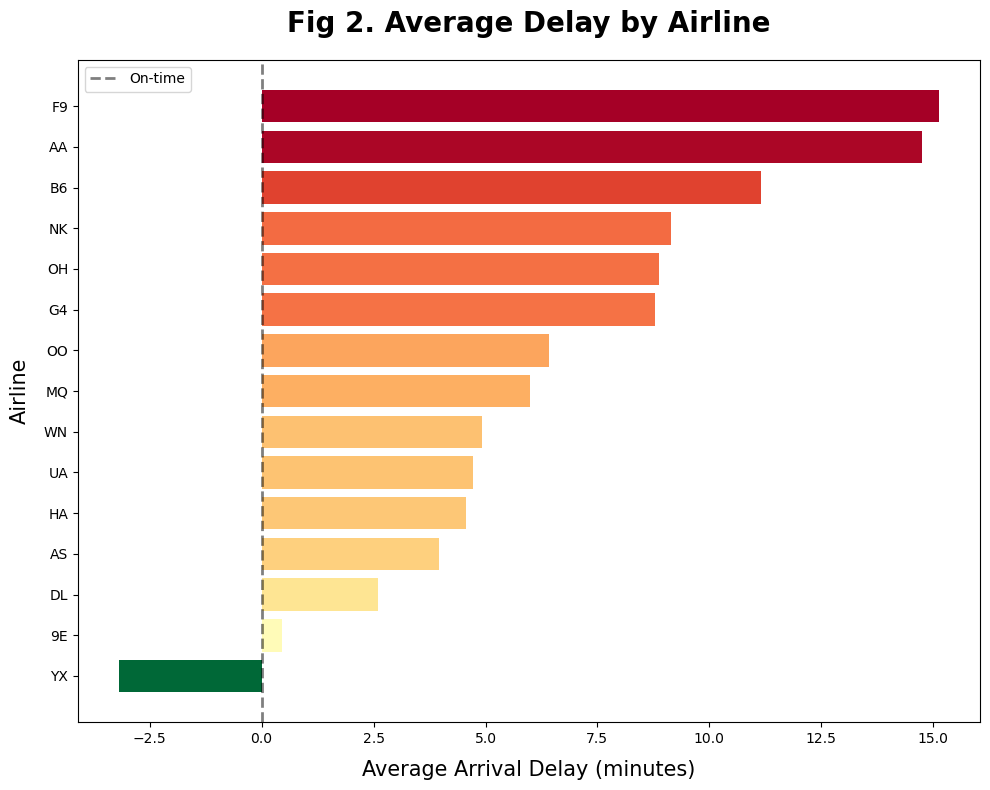

In [7]:
# Average delay by airline
airline_delays = df.groupby('OP_CARRIER')['ARR_DELAY'].mean().sort_values()

# Color map for negative and positive delays, centered at 0
norm = TwoSlopeNorm(vmin=airline_delays.min(), vcenter=0, vmax=airline_delays.max())
cmap = cm.RdYlGn_r
colors = [cmap(norm(value)) for value in airline_delays.values]

# Barplot
plt.figure(figsize=(10, 8))
plt.barh(airline_delays.index, 
         airline_delays.values, 
         color=colors)
plt.xlabel('Average Arrival Delay (minutes)', 
           fontsize=15,
           labelpad=10)
plt.ylabel('Airline', 
           fontsize=15,
           labelpad=10)
plt.title('Fig 2. Average Delay by Airline', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.axvline(x=0, 
            color='black', 
            linestyle='--', 
            linewidth=2, 
            label='On-time',
            alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

**Temporal Patterns:**

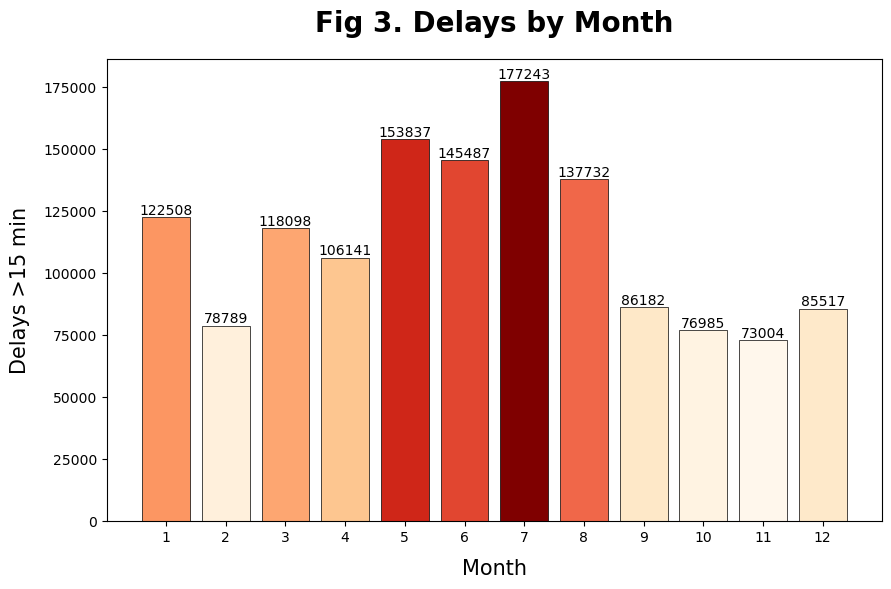

In [8]:
# Count delays over 15 minutes by month
delays_over_15 = df[df['ARR_DELAY'] > 15].groupby('MONTH').size().reindex(range(1, 13), fill_value=0)

plt.figure(figsize=(10, 6))
norm = plt.Normalize(vmin=delays_over_15.min(), vmax=delays_over_15.max())
colors = cm.OrRd(norm(delays_over_15.values))

plt.bar(delays_over_15.index, delays_over_15.values, 
        color=colors, 
        edgecolor='black', 
        linewidth=0.5)

# Add values on top of bars
for month, value in delays_over_15.items():
    plt.text(month, value, str(value), ha='center', va='bottom')

plt.xlabel('Month',
           fontsize=15,
           labelpad=10)
plt.ylabel('Delays >15 min',
           fontsize=15,
           labelpad=10)
plt.title('Fig 3. Delays by Month',
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.xticks(range(1, 13))

plt.show()

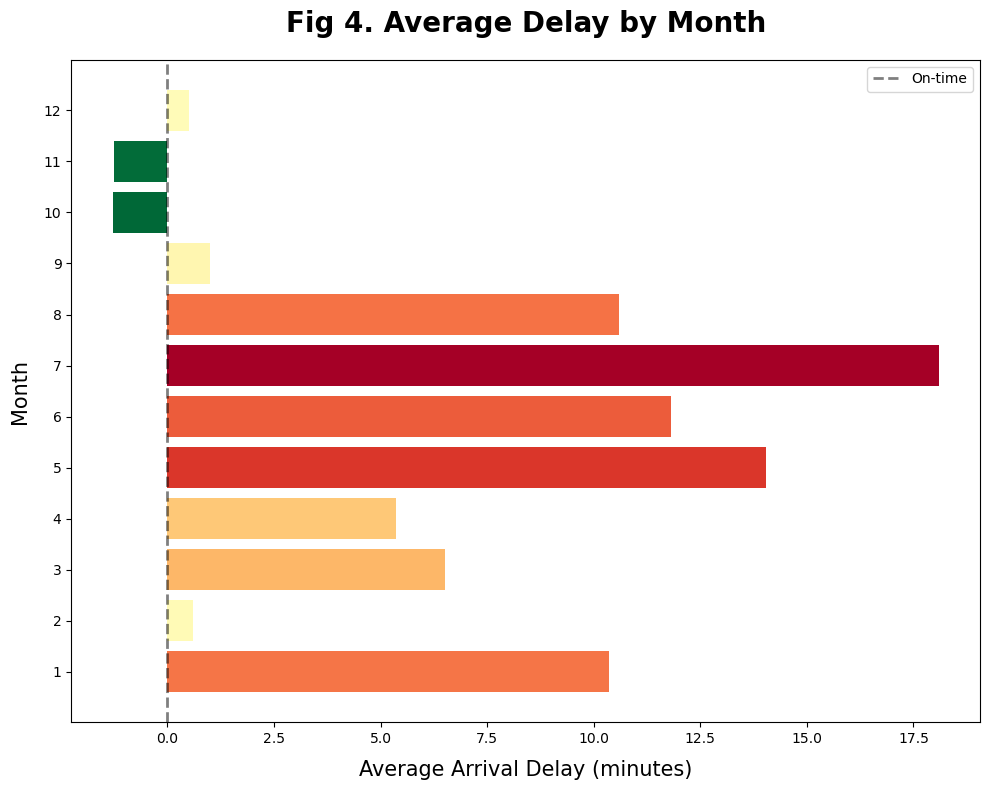

In [9]:
# Average delay by month
monthly_delays = df.groupby('MONTH')['ARR_DELAY'].mean().sort_values()

# Color map for negative and positive delays, centered at 0
norm = TwoSlopeNorm(vmin=monthly_delays.min(), vcenter=0, vmax=monthly_delays.max())
cmap = cm.RdYlGn_r
colors = [cmap(norm(value)) for value in monthly_delays.values]

# Barplot
plt.figure(figsize=(10, 8))
plt.barh(monthly_delays.index, 
         monthly_delays.values, 
         color=colors)
plt.xlabel('Average Arrival Delay (minutes)', 
           fontsize=15,
           labelpad=10)
plt.ylabel('Month', 
           fontsize=15,
           labelpad=10)
plt.title('Fig 4. Average Delay by Month', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.axvline(x=0, 
            color='black', 
            linestyle='--', 
            linewidth=2, 
            label='On-time',
            alpha=0.5)
plt.yticks(range(1, 13))
plt.legend()
plt.tight_layout()
plt.show()

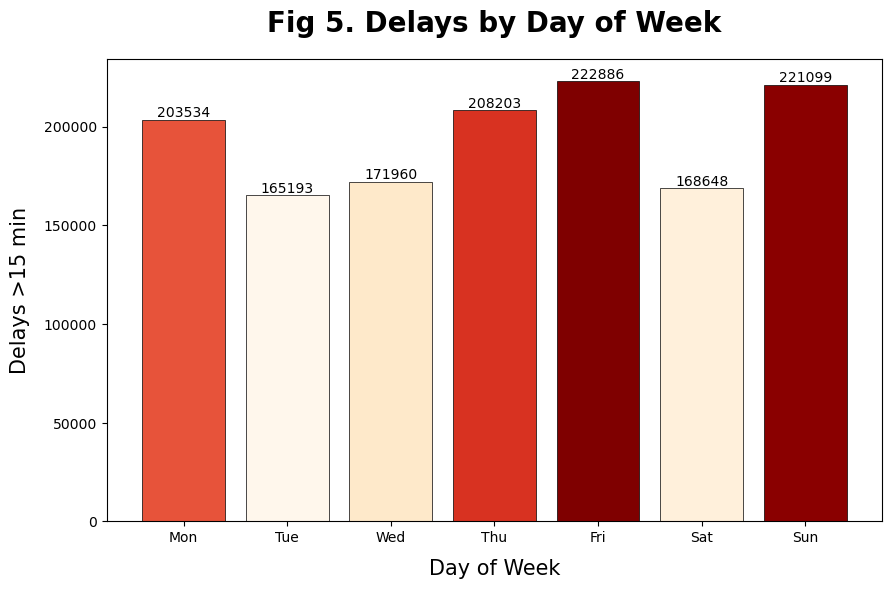

In [10]:
# Count delays over 15 minutes by day of week
delays_over_15 = df[df['ARR_DELAY'] > 15].groupby('DAY_OF_WEEK').size().reindex(range(1, 8), fill_value=0)

plt.figure(figsize=(10, 6))
norm = plt.Normalize(vmin=delays_over_15.min(), vmax=delays_over_15.max())
colors = cm.OrRd(norm(delays_over_15.values))

plt.bar(delays_over_15.index, delays_over_15.values, 
        color=colors, 
        edgecolor='black', 
        linewidth=0.5)

# Add values on top of bars
for day, value in delays_over_15.items():
    plt.text(day, value, str(value), ha='center', va='bottom')

plt.xlabel('Day of Week',
           fontsize=15,
           labelpad=10)
plt.ylabel('Delays >15 min',
           fontsize=15,
           labelpad=10)
plt.title('Fig 5. Delays by Day of Week',
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()

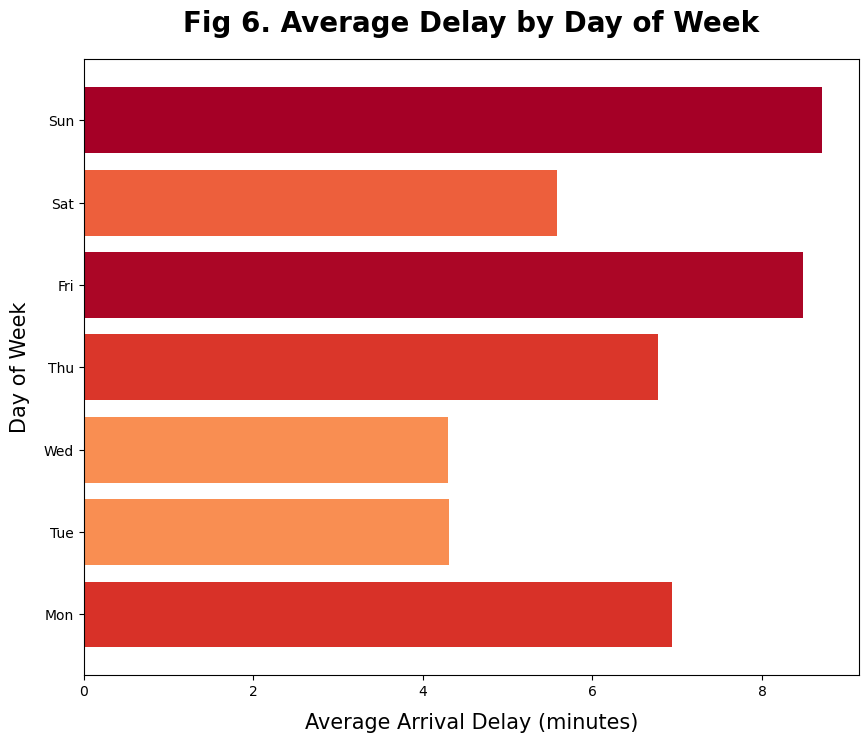

In [11]:
# Average delay by day of week
daily_delays = df.groupby('DAY_OF_WEEK')['ARR_DELAY'].mean().sort_values()

# Color map for negative and positive delays, centered at 0
vmin = min(daily_delays.min(), -0.1)
vmax = max(daily_delays.max(), 0.1)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = cm.RdYlGn_r
colors = [cmap(norm(value)) for value in daily_delays.values]

# Barplot
plt.figure(figsize=(10, 8))
plt.barh(daily_delays.index, 
         daily_delays.values, 
         color=colors)
plt.xlabel('Average Arrival Delay (minutes)', 
           fontsize=15,
           labelpad=10)
plt.ylabel('Day of Week', 
           fontsize=15,
           labelpad=10)
plt.title('Fig 6. Average Delay by Day of Week', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.yticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

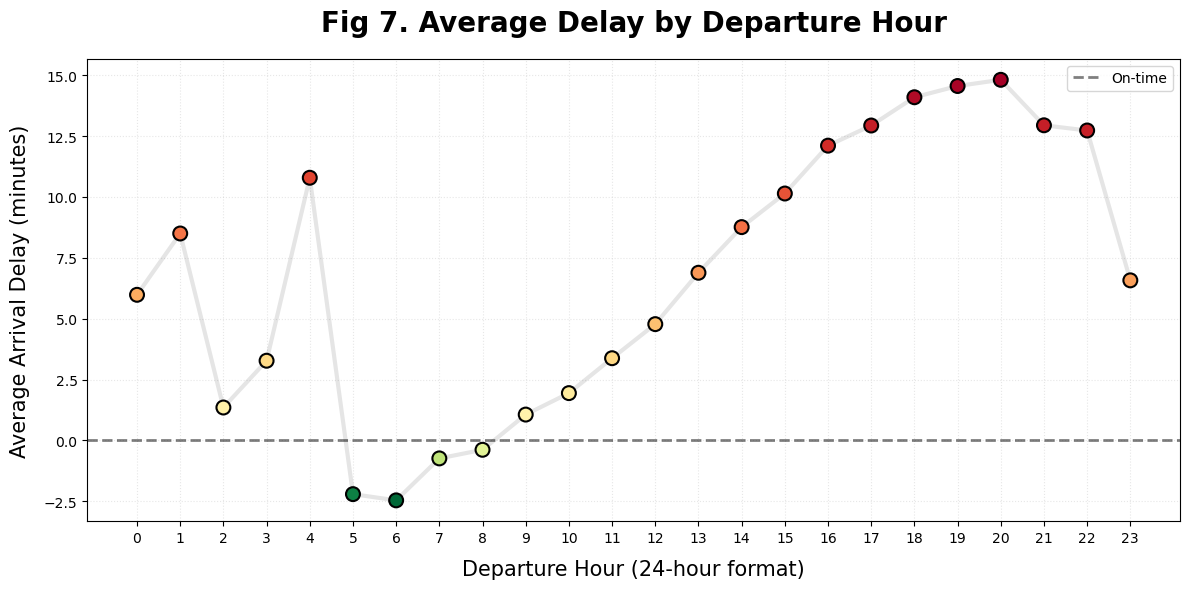

In [12]:
# Calculate hourly delays
df['DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
hourly = df[df['DEP_HOUR'] < 24].groupby('DEP_HOUR')['ARR_DELAY'].mean().sort_index()

# Color map
norm = TwoSlopeNorm(vmin=hourly.min(), vcenter=0, vmax=hourly.max())
cmap = cm.RdYlGn_r

plt.figure(figsize=(12, 6))

# Plot line
plt.plot(hourly.index, hourly.values, 
         linewidth=3, 
         color='black', 
         alpha=0.1)

# Add colored scatter points
colors = [cmap(norm(value)) for value in hourly.values]
plt.scatter(hourly.index, hourly.values, 
           c=colors, 
           s=100, 
           edgecolor='black', 
           linewidth=1.5, 
           zorder=5)

plt.xlabel('Departure Hour (24-hour format)', 
           fontsize=15,
           labelpad=10)
plt.ylabel('Average Arrival Delay (minutes)', 
           fontsize=15,
           labelpad=10)
plt.title('Fig 7. Average Delay by Departure Hour', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.axhline(y=0, 
            color='black', 
            linestyle='--', 
            linewidth=2, 
            label='On-time',
            alpha=0.5)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3, 
         linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

**Delay Types**

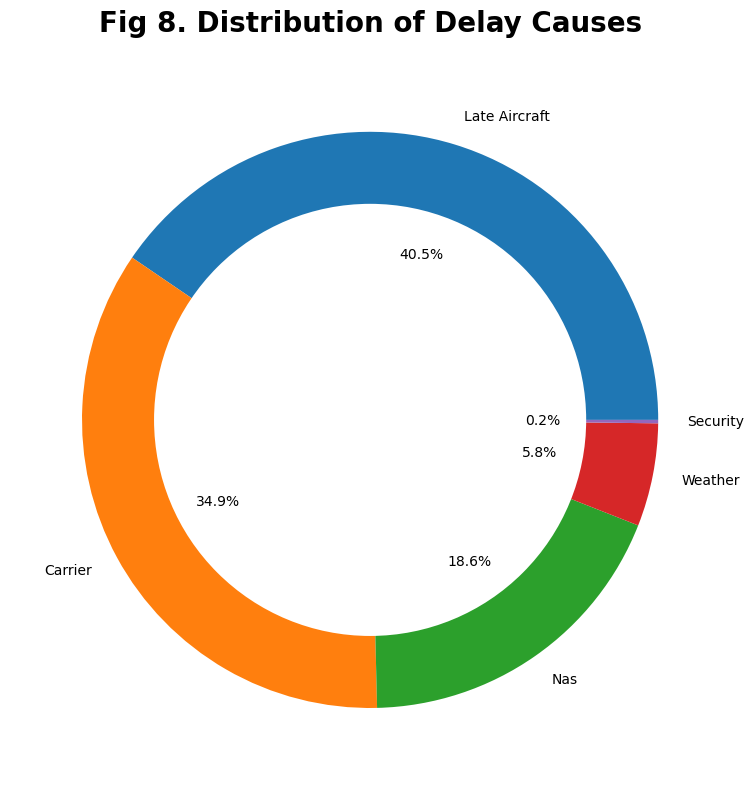

In [13]:
causes = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
cause_totals = df[causes].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.pie(cause_totals, 
        labels=[c.replace('_DELAY', '').replace('_', ' ').title() for c in cause_totals.index], 
        autopct='%1.1f%%')
plt.title('Fig 8. Distribution of Delay Causes', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.tight_layout()
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

**Correlation Matrix of Numeric Variables**

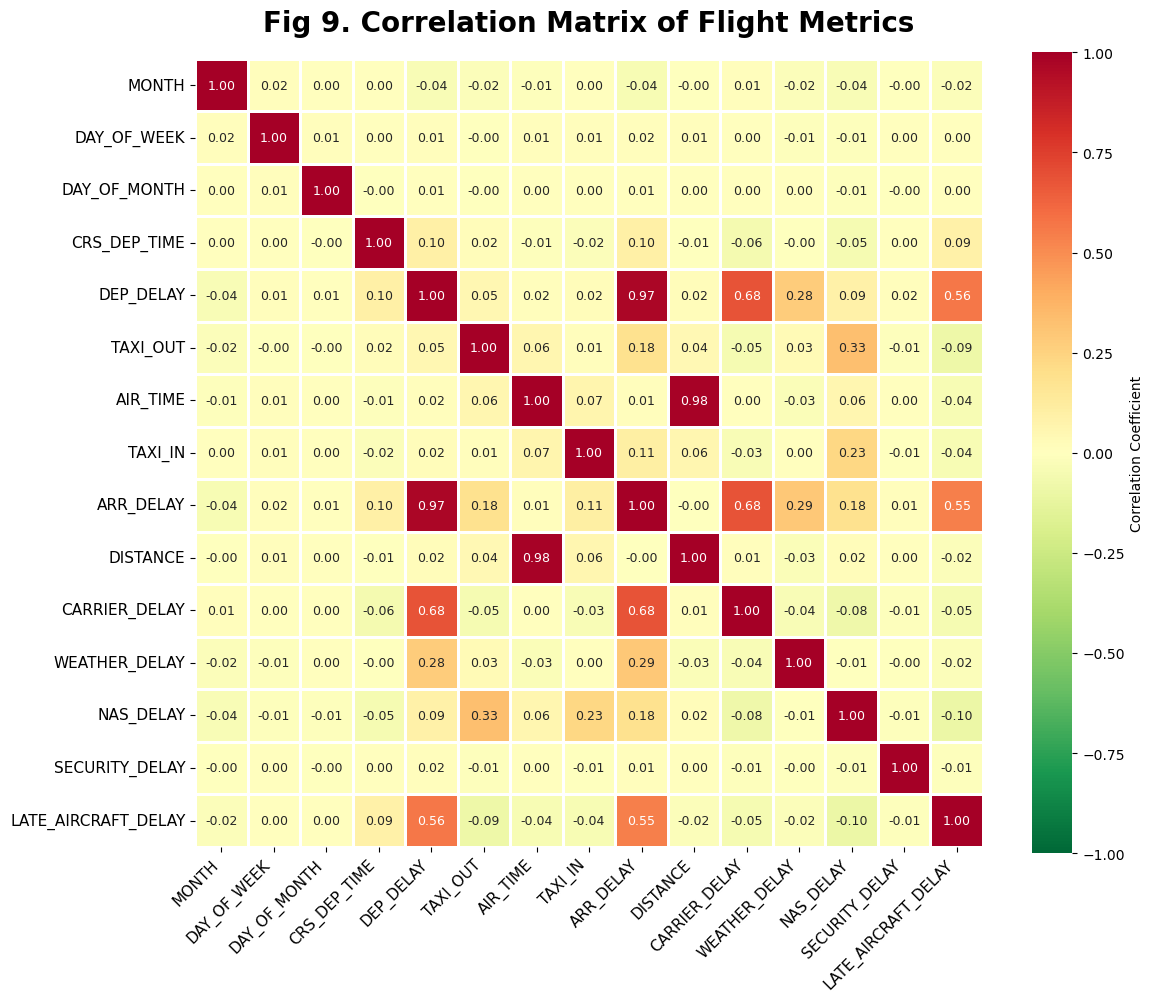

In [14]:
# Select only meaningful numeric variables
meaningful_cols = ['MONTH', 'DAY_OF_WEEK', 'DAY_OF_MONTH',
                   'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 
                   'AIR_TIME', 'TAXI_IN', 'ARR_DELAY',
                   'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 
                   'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

corr = df[meaningful_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f',
            center=0, 
            cmap='RdYlGn_r', 
            square=True,
            linewidths=1,
            linecolor='white',
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, 
            vmax=1,
            annot_kws={'fontsize': 9})

plt.title('Fig 9. Correlation Matrix of Flight Metrics', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

In [15]:
# Calculate key metrics
total = len(df)
early = (df['ARR_DELAY'] < 0).sum()
on_time = (df['ARR_DELAY'] <= 15).sum()
delayed = (df['ARR_DELAY'] > 15).sum()
cancelled = df['CANCELLED'].sum()

print(f"Total flights: {total:,}")
print(f"Early: {early:,} ({early/total*100:.1f}%)")
print(f"On-time (≤15 min): {on_time:,} ({on_time/total*100:.1f}%)")
print(f"Delayed (>15 min): {delayed:,} ({delayed/total*100:.1f}%)")
print(f"Cancelled: {cancelled:,} ({cancelled/total*100:.1f}%)")

Total flights: 7,047,267
Early: 4,334,040 (61.5%)
On-time (≤15 min): 5,576,333 (79.1%)
Delayed (>15 min): 1,361,523 (19.3%)
Cancelled: 92,664.0 (1.3%)


### Modeling and Analysis

**Logistic Regression**

In [16]:
# Prepare data
df_model = df[df['ARR_DELAY'].notna()].copy()
df_model['IS_DELAYED'] = (df_model['ARR_DELAY'] > 15).astype(int)

# Features
features = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DISTANCE', 'OP_CARRIER', 'ORIGIN', 'DEST']
df_encoded = df_model[features + ['IS_DELAYED']].copy()

# Encode
for col in ['OP_CARRIER', 'ORIGIN', 'DEST']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Split
X = df_encoded[features]
y = df_encoded['IS_DELAYED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Results
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Training time: {train_time:.2f}s")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Delayed', 'Delayed']))

cm = confusion_matrix(y_test, y_pred)

print(f"True Negatives: {cm[0,0]:,} | False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,} | True Positives: {cm[1,1]:,}")

Training time: 104.81s
Accuracy: 0.5945
ROC-AUC: 0.6309

Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.86      0.59      0.70   1115267
     Delayed       0.27      0.61      0.37    272305

    accuracy                           0.59   1387572
   macro avg       0.56      0.60      0.54   1387572
weighted avg       0.74      0.59      0.64   1387572

True Negatives: 659,145 | False Positives: 456,122
False Negatives: 106,545 | True Positives: 165,760


**Random Forrest**

In [17]:
# Random Forest (reusing X_train, X_test, y_train, y_test from above)
model_rf = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  random_state=42, 
                                  class_weight='balanced', 
                                  n_jobs=-1)

start = time.time()
model_rf.fit(X_train, y_train)
train_time_rf = time.time() - start

y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Results
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Training time: {train_time_rf:.2f}s")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Not Delayed', 'Delayed']))

cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"True Negatives: {cm_rf[0,0]:,} | False Positives: {cm_rf[0,1]:,}")
print(f"False Negatives: {cm_rf[1,0]:,} | True Positives: {cm_rf[1,1]:,}")

Training time: 460.66s
Accuracy: 0.6387
ROC-AUC: 0.6810

Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.87      0.65      0.74   1115267
     Delayed       0.30      0.61      0.40    272305

    accuracy                           0.64   1387572
   macro avg       0.58      0.63      0.57   1387572
weighted avg       0.76      0.64      0.67   1387572

True Negatives: 719,391 | False Positives: 395,876
False Negatives: 105,475 | True Positives: 166,830


**XGBoost**

In [18]:
# Class imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# XGBoost (reusing X_train, X_test, y_train, y_test from above)
model_xgb = XGBClassifier(n_estimators=100, 
                          max_depth=5, 
                          random_state=42, 
                          learning_rate=0.1, 
                          n_jobs=-1,
                          eval_metric='logloss',
                          scale_pos_weight=scale_pos_weight)

start = time.time()
model_xgb.fit(X_train, y_train)
train_time_xgb = time.time() - start

y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Results
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

#print(f"Training time: {train_time_xgb:.2f}s")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Not Delayed', 'Delayed']))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"True Negatives: {cm_xgb[0,0]:,} | False Positives: {cm_xgb[0,1]:,}")
print(f"False Negatives: {cm_xgb[1,0]:,} | True Positives: {cm_xgb[1,1]:,}")

Accuracy: 0.6380
ROC-AUC: 0.6914

Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.88      0.64      0.74   1115267
     Delayed       0.30      0.64      0.41    272305

    accuracy                           0.64   1387572
   macro avg       0.59      0.64      0.57   1387572
weighted avg       0.77      0.64      0.67   1387572

True Negatives: 711,282 | False Positives: 403,985
False Negatives: 98,280 | True Positives: 174,025



### Results

In [19]:
# Summary table
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy, accuracy_rf, accuracy_xgb],
    'ROC-AUC': [roc_auc, roc_auc_rf, roc_auc_xgb],
    'Training Time (min)': [train_time/60, train_time_rf/60, train_time_xgb/60]
})

# Add confusion matrix values
log_cm = confusion_matrix(y_test, y_pred)
rf_cm = confusion_matrix(y_test, y_pred_rf)
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

results_summary['True Positives'] = [log_cm[1,1], rf_cm[1,1], xgb_cm[1,1]]
results_summary['True Negatives'] = [log_cm[0,0], rf_cm[0,0], xgb_cm[0,0]]
results_summary['False Positives'] = [log_cm[0,1], rf_cm[0,1], xgb_cm[0,1]]
results_summary['False Negatives'] = [log_cm[1,0], rf_cm[1,0], xgb_cm[1,0]]

# Sort by ROC-AUC
results_summary = results_summary.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("MODEL COMPARISON SUMMARY")
print(results_summary.to_string(index=False))


MODEL COMPARISON SUMMARY
              Model  Accuracy  ROC-AUC  Training Time (min)  True Positives  True Negatives  False Positives  False Negatives
            XGBoost      0.64     0.69                 0.64          174025          711282           403985            98280
      Random Forest      0.64     0.68                 7.68          166830          719391           395876           105475
Logistic Regression      0.59     0.63                 1.75          165760          659145           456122           106545


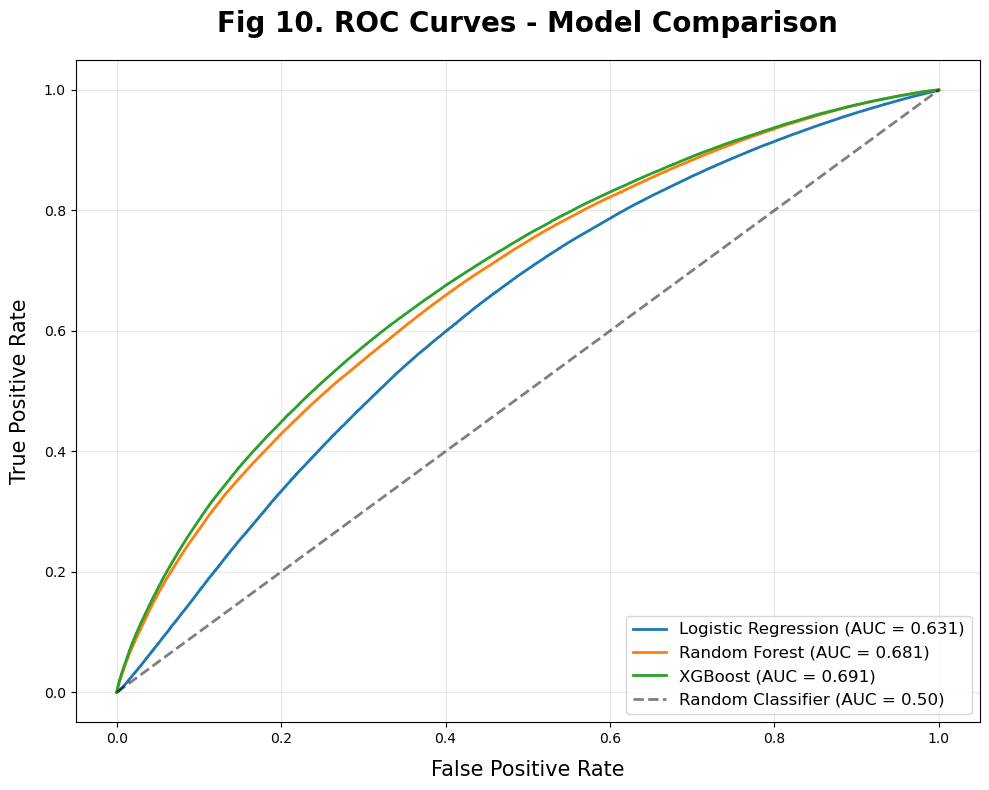

In [20]:
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_log:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf_calc = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf_calc:.3f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb_calc = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {roc_auc_xgb_calc:.3f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)', alpha = 0.5)

plt.xlabel('False Positive Rate', fontsize=15, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=15, labelpad=10)
plt.title('Fig 10. ROC Curves - Model Comparison', fontsize=20, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Get Predictions for Dashboard

In [21]:
# Unique combinations of the indepedent variables to input into the model
unique_combinations_original = df[features].drop_duplicates()

print(f"Encoded dataset has {len(df):,} rows")
print(f"Unique combinations of {features}: {len(unique_combinations_original):,}")

# Show the distribution
print("\nUnique values per feature:")
for feature in features:
    print(f"  {feature}: {unique_combinations_original[feature].nunique()} unique values")

Encoded dataset has 7,047,267 rows
Unique combinations of ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DISTANCE', 'OP_CARRIER', 'ORIGIN', 'DEST']: 2,780,115

Unique values per feature:
  MONTH: 12 unique values
  DAY_OF_WEEK: 7 unique values
  CRS_DEP_TIME: 1364 unique values
  DISTANCE: 1617 unique values
  OP_CARRIER: 15 unique values
  ORIGIN: 346 unique values
  DEST: 346 unique values


In [22]:
# Encode the original dataset with the chosen indepdent features

unique_combinations_encoded = unique_combinations_original[features].copy()
for col in ['OP_CARRIER', 'ORIGIN', 'DEST']:
    le = LabelEncoder()
    unique_combinations_encoded[col] = le.fit_transform(unique_combinations_encoded[col].astype(str))

In [23]:
# Predictions based on the XGBoost model that was trained for every unique combination that exists in the dataset

predictions = model_xgb.predict(unique_combinations_encoded)
probabilities = model_xgb.predict_proba(unique_combinations_encoded)[:, 1]

# Below creates variables based on the XGBoost model using the unique combination dataset.
df_output = unique_combinations_original.copy()
df_output['prediction'] = predictions
df_output['probability'] = probabilities
df_output['delay_status'] = np.where(predictions == 1, 'Delayed', 'Not Delayed')
df_output['is_delayed'] = predictions.astype(bool)

In [24]:
# Export combinations dataset used in dashboard
output_filename = 'flight_delay_binary_predictions.csv'
df_output.to_csv(output_filename, index=False)

In [25]:
# Summary statistics of the unique combinations dataset and predictions

print(f"Total unique combinations: {len(df_output):,}")
print(f"Not Delayed predictions: {(df_output['prediction'] == 0).sum():,}")
print(f"Delayed predictions: {(df_output['prediction'] == 1).sum():,}")
print(f"Delayed percentage: {(df_output['prediction'].mean() * 100):.1f}%")

Total unique combinations: 2,780,115
Not Delayed predictions: 1,616,148
Delayed predictions: 1,163,967
Delayed percentage: 41.9%
